In [83]:
import networkx as nx
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from  matplotlib.colors import LinearSegmentedColormap, ListedColormap
import geopandas as gpd

In [84]:
# set default font sizes for plots
import matplotlib
matplotlib.rc('xtick',labelsize=13)
matplotlib.rc('ytick',labelsize=13)
matplotlib.rc('font',size = 16)
matplotlib.rc('legend',fontsize = 14)
matplotlib.rc('figure',titlesize = 18)

In [31]:
def create_network(year):
    
    # returns a Graph object corresponding to the international relations network of the given year
    # edges have a weighted attribute which can be 1 or -1
    
    df = pd.read_csv('allies_and_enemies_1816_2014_iso.csv')

    df = df[df['year']==year]   # select one particular year
    df = df[(df['alliance'] != 0) | (df['conflict']!=0)]   #filter entries with no link
    
    df['weight'] = df['alliance']+df['conflict']+df['alliance']*df['conflict']   # merge alliances and conflicts in a single column
    df = df.drop(columns = ['alliance','conflict'])
    

    for country in ['SLU','SVG','SKN','SCN', 'SWA']:  #remove countires that aren't in the location dataframe
        df = (df[~(df['statea']==country)])  
        df = (df[~(df['stateb']==country)])
         
    # create the networks
    
    G = nx.from_pandas_edgelist(df, source ='statea', target = 'stateb', edge_attr='weight')
    
    return G


def get_countries_coordinates():
    
    # import dataframe with coordinates of countries

    countries = pd.read_csv('countries_codes_and_coordinates.csv', 
                            index_col = 'Alpha-3 code', 
                            usecols = ['Alpha-3 code', ' Country', 'Latitude (average)', 'Longitude (average)']) 

    # store the latitude and longitude (stored in df "countries") of each country in G as a dictiorary
    pos_iso = {}
    pos_name = {}

    for idx, node in enumerate(G.nodes()):

        pos_iso[node] =  [countries.loc[node, 'Longitude (average)'], countries.loc[node, 'Latitude (average)']]
        pos_name[countries.loc[node, ' Country']] = [countries.loc[node, 'Longitude (average)'], countries.loc[node, 'Latitude (average)']]
    
        if node == 'RUS':  # I prefer locating Russia in Moscow
            pos_iso[node] = [38, 56]
            pos_name[countries.loc[node, ' Country']] = [38,56]
        
    return pos_iso, pos_name
    
    


    
def plot_world_map(ax, countries_to_highlight, highlight_color = 'indianred'):
    
    # plot world map using geopandas
    
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    # country colors
    world['color'] = 0   #lightgray
                    
    world.loc[world['name'].isin(countries_to_highlight),'color'] = 1   # indianred
    
    cmap = ListedColormap(['lightgrey', highlight_color]) 
        
    world.plot( ax = ax, column = 'color', cmap = cmap, edgecolor = 'black', alpha = 0.5)

    ax.axis('off')





def draw_signed_nw(G, pos, ax, node_size = 50, node_color = 'white', pos_width = 2, neg_width = 2):
    
    # draw signed network using countries coordinates and painting the negatives edges in red color
    
    abs_G = nx.Graph()   #network without signs
    for u, v in G.edges(data = False):
        abs_G.add_edge(u,v)
        
    for u in G.nodes(data = False):
        abs_G.add_node(u)
    
    color = ['']*G.number_of_edges()
    ls = ['']*G.number_of_edges()
    width = np.zeros(len(ls))
    
    for i, (u, v, w) in enumerate(G.edges(data = True)):
        
        color[i] = 'darkgreen' if w['weight']>0 else 'red'
        ls[i] = '-' if w['weight']>0 else '--'
        width[i] = pos_width if w['weight']>0 else neg_width
        
    nx.draw_networkx_edges(G, pos = pos, ax = ax,  edge_color=color, style = ls, width = width)
    nodes = nx.draw_networkx_nodes(G,  pos = pos, ax = ax, node_size = node_size, node_color=node_color)
    nodes.set_edgecolor('k')

    

(-90.0, 90.0)

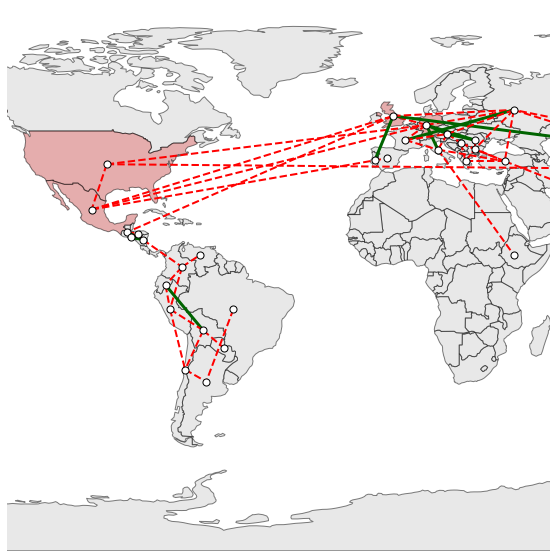

In [80]:
#####    Mexico, 1913    #####

year = 1913
countries = ['United States of America', 'United Kingdom', 'Germany', 'Mexico']

fig, ax = plt.subplots(figsize= (10,10))

G = create_network(year = year)
pos_iso, pos_name = get_countries_coordinates()
plot_world_map(ax, countries_to_highlight = countries)
draw_signed_nw(G, pos_iso, ax, pos_width = 3, neg_width = 2)

ax.set_xlim([-130,50])
ax.set_ylim([-90,90])




(21.0, 38.0)

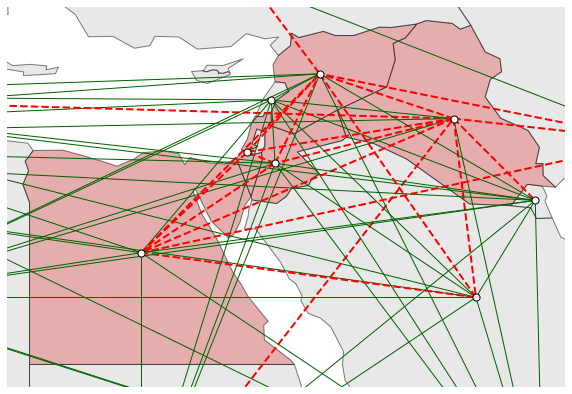

In [50]:
#####    Middle East, 1961    #####

year = 1961
countries = ['Israel', 'Egypt', 'Jordan', 'Syria', 'Iraq']

fig, ax = plt.subplots(figsize= (10,10))

G = create_network(year = year)

Subgraph_nodes = ['IRN', 'TUR', 'LBY', 'IRQ', 'TUN',  'MAR', 'SDN', 'EGY', 'SYR', 'LBN', 'JOR', 'SAU', 'YAR', 'KWT', 'ISR']
Gs = G.subgraph(Subgraph_nodes)

pos_iso, pos_name = get_countries_coordinates()
plot_world_map(ax, countries_to_highlight = countries)
draw_signed_nw(Gs, pos_iso, ax, pos_width = 1, neg_width = 2)

#Inset
ax.set_xlim([24,49])
ax.set_ylim([21,38])

# Outset
#ax.set_xlim([-10,55])
#ax.set_ylim([10,75])



(-70.0, 70.0)

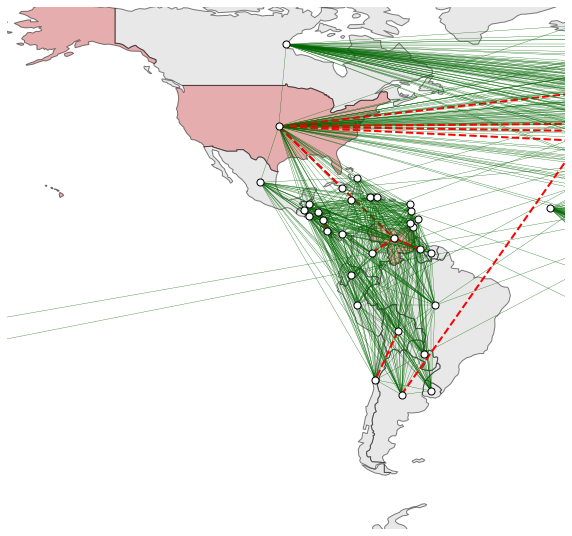

In [63]:
#####    Venezuela, 2010    #####

year = 2010
countries = ['United States of America', 'Venezuela']

fig, ax = plt.subplots(figsize= (10,10))

G = create_network(year = year)
pos_iso, pos_name = get_countries_coordinates()
plot_world_map(ax, countries_to_highlight = countries)
draw_signed_nw(G, pos_iso, ax, pos_width = 0.3, neg_width = 2)

ax.set_xlim([-170,-20])
ax.set_ylim([-70,70])


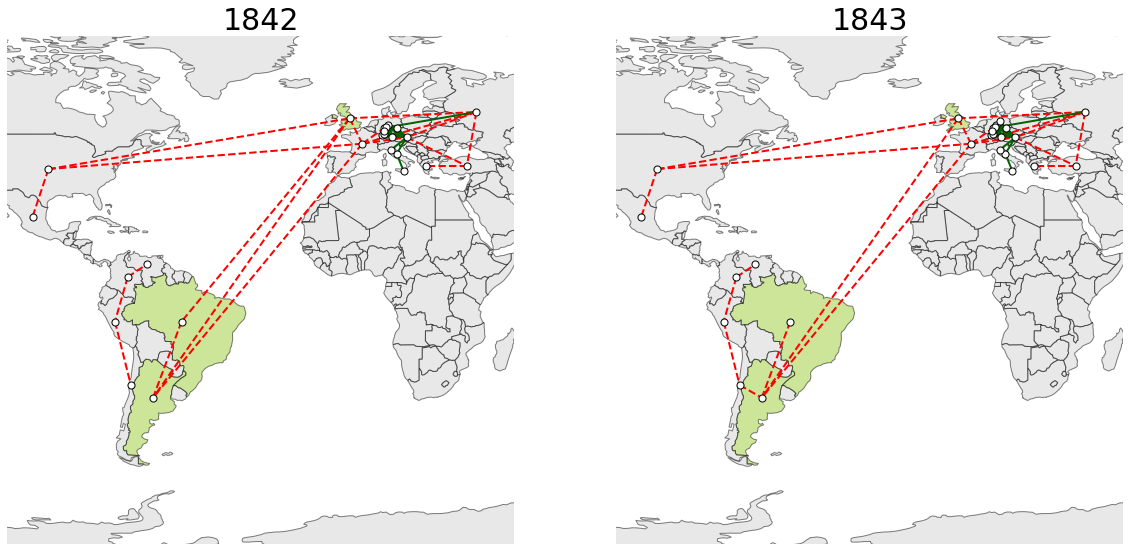

In [64]:
#####    Brazil, 1843    #####

years_v = [1842, 1843]
countries = ['Brazil', 'Argentina', 'United Kingdom']

fig, ax = plt.subplots(1,2,figsize= (20,10))

for i, year in enumerate(years_v):
    
    G = create_network(year = year)
        
    pos_iso, pos_name = get_countries_coordinates()    
    plot_world_map(ax[i], countries_to_highlight = countries, highlight_color = 'yellowgreen')
    draw_signed_nw(G, pos_iso, ax[i], pos_width = 2, neg_width = 2)

    ax[i].set_xlim([-110,50])
    ax[i].set_ylim([-80,80])
    ax[i].set_title(year, fontsize = 30)
    
plt.savefig('Brazil.pdf')

{'ZWE', 'ZAF'}
{'BWA', 'ZMB', 'MOZ', 'CUB', 'AGO'}
{'ZWE', 'ZAF', 'RUS'}
{'COD', 'BWA', 'CUB', 'ZMB', 'MOZ', 'TZA', 'AGO'}


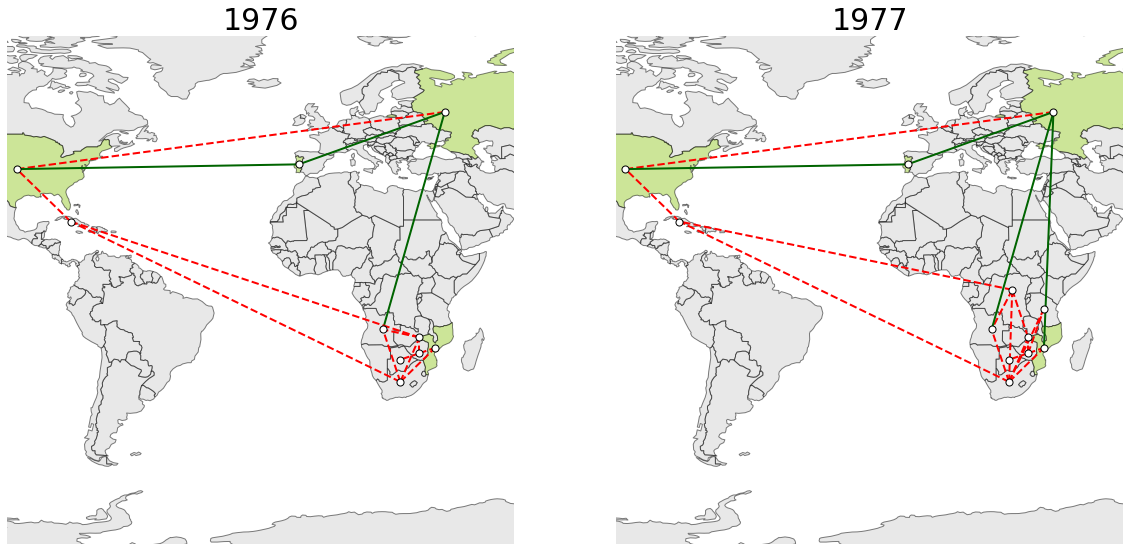

In [72]:
#####    Mozambique, 1977    #####

main_node = 'MOZ'
years_v = [1976, 1977]
countries = ['Mozambique', 'Portugal', 'Russia', 'United States of America']
countries_iso = ['MOZ', 'PRT', 'RUS', 'USA']

fig, ax = plt.subplots(1,2,figsize= (20,10))

for i, year in enumerate(years_v):
    
    G = create_network(year = year)
         
    # find neighbors
    neighbors = set(G.neighbors(main_node))
    print(neighbors)
    
    # find second neighbors
    neigh_2 = set()
    for node in neighbors:
        if node != 'RUS':
            neigh_2 = neigh_2.union(set(G.neighbors(node)))
            
    print(neigh_2)
    neigh_2 = neigh_2.union(neighbors)
    
    # create subgraph
    subgraph_nodes = set(countries_iso).union(neigh_2)
    Gs = G.subgraph(subgraph_nodes)
    
    pos_iso, pos_name = get_countries_coordinates()    
    plot_world_map(ax[i], countries_to_highlight = countries, highlight_color = 'yellowgreen')
    draw_signed_nw(Gs, pos_iso, ax[i], pos_width = 2, neg_width = 2)

    
    ax[i].set_xlim([-100,60])
    ax[i].set_ylim([-80,80])
    ax[i].set_title(year, fontsize = 30)
    
plt.savefig('Mozambique.pdf')

{'COD', 'MAR', 'ZAF', 'RUS', 'FRA'}
{'ZWE', 'COD', 'GDR', 'ZAF', 'RUS', 'ZMB'}


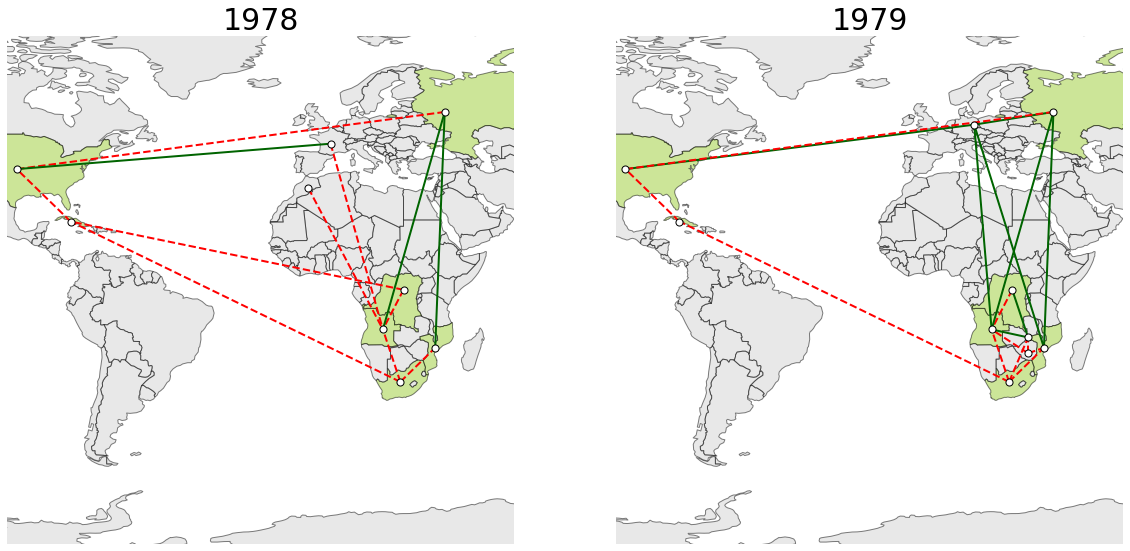

In [54]:
#####    Angola, 1978    #####

main_node = 'AGO'
years_v = [1978, 1979]
countries = ['Angola', 'United States of America', 'Russia', 'Cuba', 'Mozambique', 'South Africa', 'Dem. Rep. Congo']
countries_iso = ['AGO', 'USA', 'RUS', 'CUB', 'MOZ', 'ZAF', 'COD']  

fig, ax = plt.subplots(1,2,figsize= (20,10))

for i, year in enumerate(years_v):
    
    G = create_network(year = year)
         
    # find neighbors
    neighbors = set(G.neighbors(main_node))
    print(neighbors)
    
    # create subgraph
    subgraph_nodes = set(countries_iso).union(neighbors)
    Gs = G.subgraph(subgraph_nodes)
    
    pos_iso, pos_name = get_countries_coordinates()    
    plot_world_map(ax[i], countries_to_highlight = countries, highlight_color = 'yellowgreen')
    draw_signed_nw(Gs, pos_iso, ax[i], pos_width = 2, neg_width = 2)

    
    ax[i].set_xlim([-100,60])
    ax[i].set_ylim([-80,80])
    ax[i].set_title(year, fontsize = 30)
    
plt.savefig('Angola.pdf')

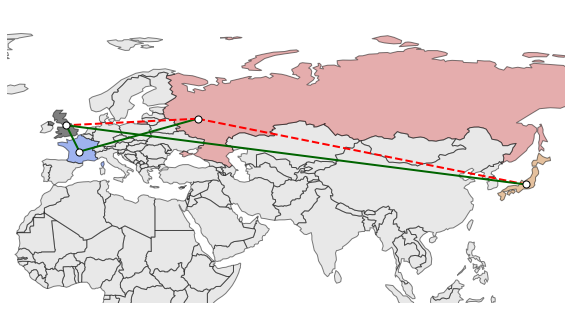

In [90]:
#####    Russo-Japanese war, 1905    #####

def plot_world_map_morecolors(ax, countries_to_highlight, highlight_color = 'indianred'):
    
    # plot world map using geopandas
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    # country colors
    world['color'] = 0   #lightgray  
    for i in range(len(countries_to_highlight)):
        world.loc[world['name'] == (countries_to_highlight[i]),'color'] = i+1
                          
    cmap = ListedColormap(['lightgrey', 'peru','royalblue','black','indianred']) 
    world.plot( ax = ax, column = 'color', cmap = cmap, edgecolor = 'black', alpha = 0.5)
    ax.axis('off')
    
year = 1905
countries = ['Japan', 'France', 'United Kingdom', 'Russia']

fig, ax = plt.subplots(figsize= (10,10))

G = create_network(year = year)
Gs = G.subgraph(['JPN', 'FRA', 'GBR', 'RUS'])
Gs = Gs.copy()
Gs.add_edge('FRA','GBR',weight = 1)
pos_iso, pos_name = get_countries_coordinates()
plot_world_map_morecolors(ax, countries_to_highlight = countries)
draw_signed_nw(Gs, pos_iso, ax, pos_width = 2, neg_width = 2)

ax.set_xlim([-20,150])
ax.set_ylim([0,90])

#plt.savefig('Example_1905.pdf')